In [1]:
import os
import sys
import importlib
import pickle

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
project_path = 'C:\\Users\\danny\\Documents_Local\\Caltech_2023-2024\\CS101'

def join_path(relative_path: str) -> str:
    return os.path.join(project_path, relative_path)

def pickle_load(relative_path: str):  # -> pickled_file_contents
    return pickle.load(open(join_path(relative_path), 'rb'))

def pickle_save(obj: object, relative_path: str) -> None:
    pickle.dump(obj, open(join_path(relative_path), 'wb'))

In [3]:
sys.path.append(join_path('EMIT-ECOSTRESS\\modules'))
import data.Datasets
import models.Feedforward
import models.Attention
import utils.train

In [4]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
device

'cuda'

In [5]:
# Make datasets and dataloaders

# setup

importlib.reload(data.Datasets)

omit_components = 6

batch_size = 256

base_data_path = (join_path('Data\\Split_Data'))

train_splits = ['00', '02', '04', '06', '08', '10', '12', '14', '16', '18']
val_splits = ['01', '05', '09', '13', '17']
test_splits = ['03', '07', '11', '15', '19']


# load data

# emit
emit_train_list = []
for split in train_splits:
    emit_train_list.append(
        pickle_load(
            os.path.join(base_data_path, f'PCA_8\\reflectance_{split}.pkl')
            # os.path.join(base_data_path, f'KPCA\\Cosine\\reflectance_{split}.pkl')
        )
    )
emit_train = np.concatenate(emit_train_list, axis=0)

emit_val_list = []
for split in val_splits:
    emit_val_list.append(
        pickle_load(
            os.path.join(base_data_path, f'PCA_8\\reflectance_{split}.pkl')
            # os.path.join(base_data_path, f'KPCA\\Cosine\\reflectance_{split}.pkl')
        )
    )
emit_val = np.concatenate(emit_val_list, axis=0)

# ecostress
eco_train_list = []
for split in train_splits:
    eco_train_list.append(
        pickle_load(
            os.path.join(base_data_path, f'LSTE\\LSTE_{split}.pkl')
        )
    )
eco_train = np.concatenate(eco_train_list, axis=0)

eco_val_list = []
for split in val_splits:
    eco_val_list.append(
        pickle_load(
            os.path.join(base_data_path, f'LSTE\\LSTE_{split}.pkl')
        )
    )
eco_val = np.concatenate(eco_val_list, axis=0)

# elevation
elev_train_list = []
for split in train_splits:
    elev_train_list.append(
        pickle_load(
            os.path.join(base_data_path, f'Elevation\\elevation_{split}.pkl')
        )
    )
elev_train = np.concatenate(elev_train_list, axis=0)

elev_val_list = []
for split in val_splits:
    elev_val_list.append(
        pickle_load(
            os.path.join(base_data_path, f'Elevation\\elevation_{split}.pkl')
        )
    )
elev_val = np.concatenate(elev_val_list, axis=0)


# create datasets and dataloaders

train_dataset = data.Datasets.EmitEcostressDataset(
    emit_data=emit_train,
    omit_components=omit_components,
    ecostress_data=eco_train,
    ecostress_center=None,
    ecostress_scale=None,
    additional_data=(elev_train,),
    device=device,
)

val_dataset = data.Datasets.EmitEcostressDataset(
    emit_data=emit_val,
    omit_components=omit_components,
    ecostress_data=eco_val,
    ecostress_center=None,
    ecostress_scale=None,
    additional_data=(elev_val,),
    device=device,
)

train_loader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, drop_last=True
)
val_loader = DataLoader(
    dataset=val_dataset, batch_size=batch_size, drop_last=True
)

In [6]:
# Make model, optimizer, and loss function
importlib.reload(models.Feedforward)
importlib.reload(models.Attention)

n_epochs = 100

model = models.Feedforward.ToyModel(
    input_dim=train_dataset.input_dim
)

if device == 'cuda':
    model = model.cuda()

optimizer = optim.Adam(
    params=model.parameters(), lr=0.0001, weight_decay=0, fused=True
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, factor=0.5, patience=2
)
# scheduler = None

loss_fn = nn.MSELoss(reduction='sum')

model

ToyModel(
  (linear1): Linear(in_features=3, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=16, bias=True)
  (linear3): Linear(in_features=16, out_features=8, bias=True)
  (linear_output): Linear(in_features=8, out_features=1, bias=True)
  (layernorm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (layernorm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  (layernorm3): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
)

In [7]:
importlib.reload(utils.train)
train_loss, val_loss = utils.train.train(
    model,
    optimizer,
    scheduler,
    loss_fn,
    train_loader,
    val_loader,
    n_epochs=n_epochs,
    loss_interval=1,
    # preexisting_losses=[train_loss, val_loss],
    device=device,
)

Epoch 000		 Train Loss: 0.89879		 Val Loss: 0.88934 		 Avg Error: 11.178		LR: 0.0001		Time: 1.3e+02
Epoch 001		 Train Loss: 0.3058		 Val Loss: 0.2927 		 Avg Error: 6.4127		LR: 0.0001		Time: 2.3e+02
Epoch 002		 Train Loss: 0.22094		 Val Loss: 0.268 		 Avg Error: 6.1362		LR: 0.0001		Time: 1.6e+02
Epoch 003		 Train Loss: 0.18868		 Val Loss: 0.30205 		 Avg Error: 6.5143		LR: 0.0001		Time: 1.3e+02
Epoch 004		 Train Loss: 0.16764		 Val Loss: 0.24596 		 Avg Error: 5.8784		LR: 0.0001		Time: 1.4e+02
Epoch 005		 Train Loss: 0.17674		 Val Loss: 0.26725 		 Avg Error: 6.1275		LR: 0.0001		Time: 1.4e+02
Epoch 006		 Train Loss: 0.16836		 Val Loss: 0.25551 		 Avg Error: 5.9914		LR: 0.0001		Time: 1.4e+02
Epoch 007		 Train Loss: 0.1683		 Val Loss: 0.23902 		 Avg Error: 5.7949		LR: 0.0001		Time: 1.3e+02
Epoch 008		 Train Loss: 0.16375		 Val Loss: 0.23511 		 Avg Error: 5.7473		LR: 0.0001		Time: 1.3e+02
Epoch 009		 Train Loss: 0.15886		 Val Loss: 0.23143 		 Avg Error: 5.7021		LR: 0.0001		Time: 1.3e+02
Epoch

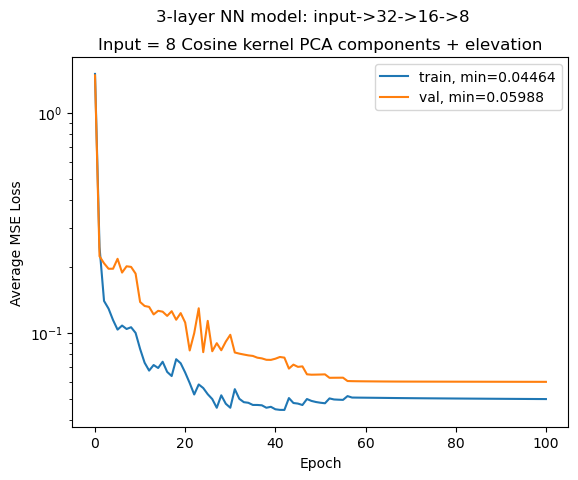

In [ ]:
fig, ax = plt.subplots()
fig.suptitle('3-layer NN model: input->32->16->8')
ax.set_title('Input = 2 PCA-whitening components + elevation')
ax.semilogy(
    np.arange(len(train_loss)),
    train_loss,
    label=f'train, min={min(train_loss):.4}',
)
ax.semilogy(
    np.arange(len(val_loss)), val_loss, label=f'val, min={min(val_loss):.4}'
)
ax.set_xlabel('Epoch')
ax.set_ylabel('Average MSE Loss')
ax.legend()
plt.show(fig)